## Introduction {.unnumbered}

In [part 1](https://www.subelsky.com/crimegraph/street_graph_feature_engineering/) and [part 2](https://www.subelsky.com/crimegraph/event_timestep_feature_engineering/) of the CrimeGraph project, we performed feature engineering on the spatial and temporal data of the [SpotCrime](https://spotcrime.com/) crime event dataset.

In part 3, we will build the first version of a graph neural network model and train it to make rudimentary predictions for the risk of violent crime events. We are using the GLDNet^[Gated Localized Diffusion] architecture described in the 2020 paper _[Graph Deep Learning Model for Network-based Predictive Hotspot Mapping of Sparse Spatio-Temporal Events](https://discovery.ucl.ac.uk/id/eprint/10085742/)_.

The source code is available on [GitHub](https://github.com/subelsky/crimegraph).

## Load Street Graph and Crime Events

We begin by loading the street graph which stores each street segments as nodes. Intersections between segments are modeled as edges connecting nodes. Each edge has a `weight` representing the network strength of the relationship between streets. See [part 1](https://www.subelsky.com/crimegraph/street_graph_feature_engineering/) for details.

In [134]:
#| code-fold: true
import pickle

file_path = '../../data/processed/baltimore_street_graph.gpickle'

with open(file_path, 'rb') as f:
    G = pickle.load(f)

print('Sample street nodes (first number is the NodeIndex used in the events dataframe):\n')

for node in list(G.nodes.data())[None:5:None]:
    print(node)

print("\nSample edges ('weight' is the network strength of the relationship between streets):\n")

for edge in list(G.edges.data())[None:5:None]:
    print(edge)

Sample street nodes (first number is the NodeIndex used in the events dataframe):

(0, {'NodeID': 367225, 'name': 'N DUKELAND ST', 'position': (429023.8628222718, 181450.00684655222)})
(1, {'NodeID': 367456, 'name': 'W READ ST', 'position': (433112.90626279684, 181374.68178852845)})
(2, {'NodeID': 367483, 'name': 'REMINGTON AVE', 'position': (432440.1964178119, 184064.86845014035)})
(3, {'NodeID': 367488, 'name': 'CANTERBURY RD', 'position': (432716.56154741155, 185417.96152212998)})
(4, {'NodeID': 367592, 'name': 'SWEET AIR ST', 'position': (431223.7876548111, 184620.00943614714)})

Sample edges ('weight' is the network strength of the relationship between streets):

(0, 89, {'distance': 207.24859639546855, 'weight': 0.9625401124585142})
(0, 169, {'distance': 170.25866131463928, 'weight': 0.9745620176687882})
(0, 256, {'distance': 287.5199729004246, 'weight': 0.9291524699760467})
(0, 498, {'distance': 581.1777592139317, 'weight': 0.7406420337058561})
(0, 545, {'distance': 76.508199396

Next, we load the crime event timesteps prepared in [part 2](https://www.subelsky.com/crimegraph/event_timestep_feature_engineering/) by mapping each event to the nearest street segment node. `NodeIndex` refers to the position of the node in the street graph's index.

The feature columns are named '*SMOOTHED' because the values for each timestep were exponentially smoothed across the preceding timesteps in part 2, to facilitate neural network training.

In [135]:
#| code-fold: true
import pandas as pd

file_path = '../../data/processed/timesteps.csv.gz'

# Load the timesteps dataframe, ensuring that integer columns are read as integers
timesteps = pd.read_csv(file_path, dtype={'NodeIndex': 'int', 'Arrest': 'int', 'Property': 'int', 'Violent': 'int'})

# Groups the timesteps by date and node index so we can construct a tensor representing timesteps x num_nodes x features
timesteps.reset_index(inplace=True)
timesteps.set_index(['Date', 'NodeIndex'], inplace=True)

# Exclude the columns 'Arrest' and 'Property' for now, although we may want to use them later
# if we experiment with new exponential smoothing factors during hyperparameter tuning
feature_columns = ['ArrestSmoothed', 'PropertySmoothed', 'ViolentSmoothed']

# The label column is what we want the model to predict, one day in the future
label_column = 'Violent'

# Filter the timesteps DataFrame to keep only the feature columns and label
timesteps = timesteps[feature_columns + [label_column]]

timesteps.head()

ArrestSmoothed  PropertySmoothed  ViolentSmoothed  \
Date       NodeIndex                                                      
2015-01-01 0                     0.0               0.0              2.0   
           27                    0.0               0.0              1.0   
           36                    0.0               1.0              0.0   
           44                    0.0               1.0              1.0   
           53                    1.0               0.0              0.0   

                      Violent  
Date       NodeIndex           
2015-01-01 0                2  
           27               1  
           36               0  
           44               1  
           53               0

In order to save computation time and memory, a subset of crime events was selected across a representative swath of Baltimore neighborhoods:

![City of Baltimore overlaid with crime event subset](baltimore_event_subset.png)

## Create Data Tensor

We can now unify the spatial and temporal data into a single object suitable for training a neural network: a _tensor_.

ChatGPT gave me a pretty good general purpose definition of tensor:

> "...a mathematical way to represent a collection of numbers that might have various layers of depth. A single number is called a scalar, a list of numbers is a vector (like a row or column in a spreadsheet), and a grid of numbers is a matrix (like a whole spreadsheet).

> A tensor extends this idea to even more dimensions, allowing for a more comprehensive representation of information, which is essential in tasks like image recognition or language processing in machine learning."

In [136]:
from lib.data import create_data_tensor

num_nodes = G.number_of_nodes()
data_tensor = create_data_tensor(timesteps, num_nodes, feature_columns)

In [137]:
#| code-fold: true
print(f'Shape of data tensor: {data_tensor.shape}')
print(f'Number of days: {data_tensor.shape[0]}')
print(f'Number of nodes: {data_tensor.shape[1]}')
print(f'Number of channels per node: {data_tensor.shape[2]}')

Shape of data tensor: (3232, 1177, 4)
Number of days: 3232
Number of nodes: 1177
Number of channels per node: 4


`data_tensor` now contains a 3D tensor with shape `(timesteps, nodes, features)`: 

For each of the `3232` days in the timesteps dataset:

* There are `1177` feature vectors, one for each of the `1177` street segment nodes

* Each feature vector contains `3` numerical features (`ArrestSmoothed`, `PropertySmoothed`, and `ViolentSmoothed`).

* Each feature vector contains `1` additional channel, `Violent`: the non-smoothed violent crime count for each node. `Violent` is the target variable for the model, known as the _label_. For any given date at a given node, `Violent` is the number of violent crimes that should have been predicted for that node on that date.

## Establish Important Hyperparameters

There are many hyperparameters that can be tuned to improve the performance of a neural network. We start with a few that are important to the GLDNet architecture. These initial default values were chosen based on the ones used in the original paper:

In [138]:
# Deep learning models typically train with several examples at a time, called a batch
batch_size = 16

# Governs the misprediction cost for nodes with zero violent crimes
loss_rho = 0.03

# Used to calculate "hit rate" accuracy, by scoring predictions from the top 20% of street segments
hit_rate_coverage = 0.2

# Defines the number of times the model will see each example during training
epochs = 15

## Create Training, Validation, and Test Sets

To prevent the model from simply memorizing the training data (known as 'overfitting'), we create three data sets:

* `training_data`: used to train the model (70%)
* `validation_data`: used to evaluate performance during training (10%)
* `test_data`: used to evaluate the final performance of the model (20%)

Because the model only learns from `training_data`, we use the remaining 30% to keep the model honest. Since this is a time forecasting problem, we use the newest events for evaluation: temporal patterns can change over time, and we want near-term predictions to use the most recent events for inference.

In [139]:
from lib.data import create_dataset

total_windows = data_tensor.shape[0]

training_window_size = int(0.7 * total_windows)
validation_window_size = int(0.10 * total_windows)

# Use the first 70% of the data for training
training_slice = data_tensor[:training_window_size]
training_data = create_dataset(training_slice)

# Use the next 10% for validation while training
validation_slice = data_tensor[training_window_size:training_window_size + validation_window_size]
validation_data = create_dataset(validation_slice)

# Use the remaining, most recent 20% of the data for testing after training is complete
test_data = data_tensor[training_window_size + validation_window_size:]
test_data = create_dataset(test_data)

# Controls how well-shuffled the training data is before each epoch;
# since our dataset is relatively we small, we can afford to shuffle it completely,
# meaning the shuffle buffer size is equal to the number of examples in the training set
shuffle_buffer_size = training_data.cardinality()

# Shuffles the training data so that the model sees examples in random order for every training epoch;
# also batches the training data into groups of examples
training_data = training_data.shuffle(shuffle_buffer_size).batch(batch_size)

# Validation and test data do not need to be shuffled, but are still batched, because the model
# will have been trained to handle batches of examples
validation_data = validation_data.batch(batch_size)
test_data = test_data.batch(batch_size)

## Create Metrics

We need a way to measure the performance of the model. Following the GLDnet paper, we will adopt "hit rate accuracy" as our metric. Hit rate compares the number of successful predictions against actual violent crime occurrences for the most active segments of a timestep (in this case, the 20% of street segments with the most violent crime events).

Zhang and Cheng explain the metric in their paper:

 > To calculate the hit rate, we first compute the prediction on each street segment, and then sort all segments by the predicted values in descending order. The street segments are selected in the sorted order and the proportion of the events falling on those street segments is tallied. ... the hit rate is computed at maximum 20% street length coverage and the mean of the hit rates over all consecutive testing days is used as the metric for predictive mapping assessment.

In [140]:
from lib.metrics import HitRateMetric

metrics = [HitRateMetric(num_nodes, hit_rate_coverage)]

## Create a Baseline Model

The simplest possible model would predict that the number of violent crimes occurring tomorrow would equal the number of violent crimes occurring today. Such a model doesn't learn from the data and cannot be trained. We will use this as a baseline for our GLDNet performance; any model we build has to beat this 'naive' model.


In [141]:
from lib.model import build_naive_model
from lib.training import test_model

naive_model = build_naive_model(metrics, loss_rho=loss_rho)
test_model(naive_model, test_data, batch_size, metrics)

{'hit_rate': 0.33807498}

`0.34` seemed surprisingly high to me, but it probably reflects obvious patterns in the data. If crime is consistently concentrated in some areas, even a simple model like this could perform reasonably well.

## Create the GLDNet Model

The GLDNet architecture combines two neural network components:

* **Gated Network**: learns long-range temporal dependencies between events. The gate determines which features of the event data to emphasize or suppress. Gated networks perform better with sparse data like ours (where most nodes on any given timestep will have zero crimes) than other types of models.

* **Localized Diffusion Network**: learns spatial dependencies across the street graph. The network models how events in one location influence other locations by treating events as a diffusion process, whereby each event creates information that 'diffuses' from one node to another.

A final, 'Dense' layer is added to the model, which learns to map the output of the Gated and Localized Diffusion networks into a single value for each node: the predicted number of violent crimes at that node in the next, future timestep.

The GLDNet paper contains a nice illustration of the entire system:

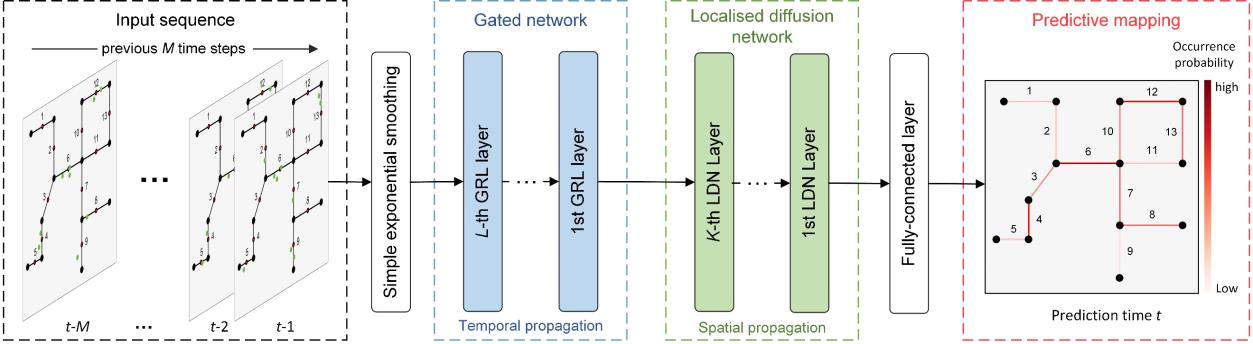

In [148]:
from lib.model import build_model
from lib.create_adjacency_matrix import create_adjacency_matrix

# The adjacency matrix represents all of the weighted edges between nodes;
# the LocalizedDiffusionNetwork uses these weights to learn network structure
adjacency_matrix = create_adjacency_matrix(G)

model = build_model(adjacency_matrix,
                    metrics,
                    loss_rho=loss_rho,
                    num_gated_relu_layers=4)

## Train the GLDNet Model

We now train the model with the `training_data` we built earlier and test it using `test_data`:

In [149]:
training_history = model.fit(training_data, epochs=epochs, validation_data=validation_data, verbose=0)

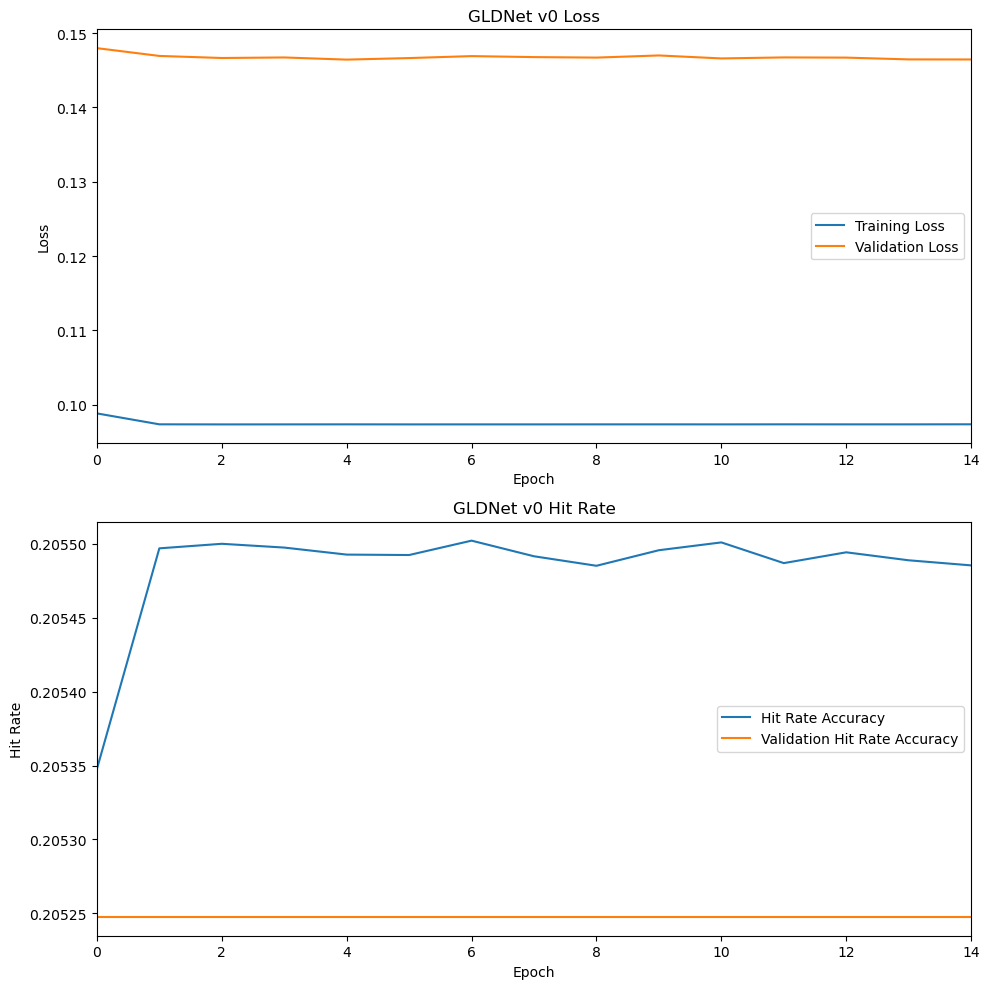

In [150]:
#| code-fold: true
from lib.plots import plot_loss_and_metrics

plot_loss_and_metrics(training_history.history, name='GLDNet v0')

In [151]:
test_model(model, test_data, batch_size, metrics)

{'hit_rate': 0.2022182}

`0.20` hit rate accuracy is significantly worse than the baseline model. To improve accuracy, we'll need to test many hyperparameter configurations that govern the training process, the complexity of the model, and how the model learns. The relatively flat loss curve above suggests that with these hyperparameters, the model is learning very little from the training data.

I experimented locally with the `rho` parameter (which affects how the loss function weighs the influence of nodes where `Violent` is `0`), and was able to get a more promising result by setting `rho = 0.3666666666666667`:

![GLDNet Training History Early Result](training_small_subset_rho_0.3666666666666667.png)

## Up Next

Now we have a working model, it's time to build a robust pipeline to test many combinations of hyperparameters. Our goal will be to find the best model and best training process for predicting crime events.